In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [2]:
from pathlib import Path
import os

data_dir = Path('./data/')
data_path = Path('./data/fashion_mnist.npz')

if data_path.is_file():
    print('Data found. Loading...')
    data = np.load(data_path)
    X_train, Y_train, X_test, Y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
else:
    print('Data not found. Downloading...')
    if not data_dir.is_dir():
        os.mkdir(data_dir)
    from keras.datasets import fashion_mnist
    (X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
    np.savez_compressed(data_path, X_train, Y_train, X_test, Y_test)

Data found. Loading...


In [3]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
CLASS_LABELS = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

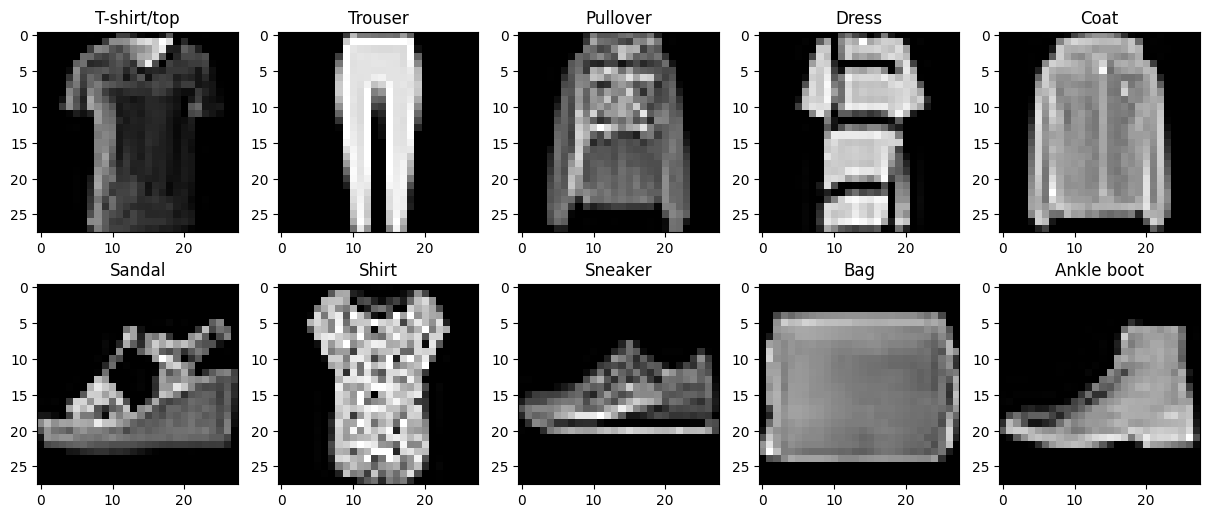

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    row_no = i//5
    col_no = i%5
    X_sub = X_train[Y_train==i]
    index = np.random.choice(a=range(len(X_sub)), size=1)
    ax[row_no][col_no].imshow(X_sub[index].reshape((28, 28)), cmap='gray')
    ax[row_no][col_no].set_title(CLASS_LABELS[i])

## Activations

In [9]:
class Sigmoid():
    """
    Implements the sigmoid logistic function, f(x) = 1/(1 + exp(-x))
    """
    def __init__(self) -> None:
        pass

    def forward(self, x):
        """
        Returns sigmoid(x) for input x
        """
        self.input = x
        self.output = 1 / (1 + np.exp(-x))
        return self.output
    
    def backward(self):
        """
        Returns gradient of sigmoid outputs wrt inputs
        """
        return self.output * (1 - self.output)

In [12]:
class Softmax():
    """
    Implements the softmax function, f(x) = exp(x) / sum(exp(x))
    """
    def __init__(self) -> None:
        pass

    def forward(self, x):
        """
        Returns softmax(x) for input x
        """
        self.input = x
        exp_x = np.exp(x)
        total = np.sum(exp_x)
        self.output = exp_x / total
        return self.output
    
    def backward(self, y_true):
        """
        Returns gradient of softmax outputs wrt inputs
        """
        e_l = np.zeros(len(self.output))
        e_l[y_true] = 1.
        return self.output[y_true] * (e_l - self.output)

## Loss functions

In [10]:
class CrossEntropyLoss():
    """
    Implements the cross entropy loss, L(y_hat, y) = -log(y_hat[y]) [where y is the true class label, from 0 to num_classes-1]
    """
    def __init__(self) -> None:
        pass

    def forward(self, y_pred, y_true):
        """
        Returns the loss for predicted probabilities y_pred, with true class label y_true
        """
        return -np.log(y_pred[y_true])
    
    def backward(self, y_pred, y_true):
        """
        Returns the derivative of the loss wrt the predicted probability of the true class y_true
        """
        return -1 / y_pred[y_true]
    
# Remember, these activations and loss have been implemented for a single data point, and need to be implemented more rigorously for multiple inputs at once

## Feedforward neural network

In [6]:
class Layer():
    """
    Models a single layer of a feedforward neural network. 

    Args:
        input_size (int): number of inputs to the layer
        output_size (int): number of outputs produced by the layer
        activation (str, optional): activation function used by the layer. 
            Allowed activations: 'identity', 'sigmoid', 'tanh', 'relu', 'softmax'
            Defaults to 'sigmoid'.
        weight_init (str, optional): type of initialization to be performed for the weights and biases
            Allowed initializations: 'random', 'xavier'
            Defaults to 'random'.
    """
    def __init__(
        self,
        input_size: int,
        output_size: int,
        activation: str = 'sigmoid',
        weight_init: str = 'random'
    ) -> None:
        # Handle to allow weight init
        self.w = np.random.normal(size=(output_size, input_size))   # shape: (output_size, input_size)
        self.b = np.random.normal(size=(output_size,))  # shape: (output_size,)
        self.activation = Sigmoid() # Handle after implementing the other activation functions
    
    def forward(self, x: np.array) -> np.array:
        """
        Computes the output of the layer for given input.

        Arg: x (numpy.array): the input vector for the layer, of size (input_size,)
        Returns: h (numpy.array): the output produced by the layer, of size (output_size,)
        """
        self.input = x
        self.pre_activation = np.matmul(self.w, x) + self.b
        self.output = self.activation.forward(self.pre_activation)
        return self.output
    
    def backward(self, accumulated_grads):
        # Get grad(self.output) wrt self.w and self.b, and use accumulated_grads to get grad(loss) wrt self.w and self.b
        pass

In [7]:
class FeedForwardNeuralNetwork():
    """
    Models a vanilla feedforward neural network, with softmax activation for the outputs.

    Args:
        input_size (int): size/dimension of inputs given to the network
        output_size (int): number of outputs produced by the network
        num_layers (int): number of hidden layers in the network
        hidden_size (int): number of neurons per hidden layer
        activation (str, optional): activation function for the hidden layers.
            Allowed activations: 'identity', 'sigmoid', 'tanh', 'relu', 'softmax'
            Defaults to 'identity'.
        weight_init (str, optional): type of initialization to be performed for the weights and biases
            Allowed initializations: 'random', 'xavier'
            Defaults to 'random'.
    """
    def __init__(
        self,
        input_size: int,
        output_size: int,
        num_layers: int,
        hidden_size: int,
        activation: str = 'identity',
        weight_init: str = 'random'
    ) -> None:
        self.input_layer = Layer(input_size, hidden_size, activation, weight_init)
        self.hidden_layers = []
        for i in range(num_layers):
            self.hidden_layers.append(Layer(hidden_size, hidden_size, activation, weight_init))
        self.output_layer = Layer(hidden_size, output_size, 'softmax', weight_init)
    
    def forward(self, x: np.array) -> np.array:
        """
        Computes the output of the network for given input.

        Arg: x (numpy.array): the input to the network, of size (input_size,)
        Returns: y_hat (numpy.array): the output produced by the network, of size (output_size,)
        """
        result = self.input_layer.forward(x)
        for hidden_layer in self.hidden_layers:
            result = hidden_layer.forward(result)
        return self.output_layer.forward(result)
